In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

from scipy.special import expit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, RocCurveDisplay, classification_report
from sklearn.preprocessing import StandardScaler

from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


*The section below requires a kaggle key in the root directory*

In [2]:
# Download dataset to 'files/' in local working directory and unzip files
! kaggle datasets download -d vjchoudhary7/hr-analytics-case-study -p files/
with zipfile.ZipFile('files/hr-analytics-case-study.zip', 'r') as zip_ref:
    zip_ref.extractall(path='files')

hr-analytics-case-study.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
path = 'files/'

for f in glob.glob(os.path.join(path, '*.csv')):
    variable_name = os.path.splitext(os.path.basename(f))[0]
    globals()[variable_name] = pd.DataFrame(pd.read_csv(f))

In [4]:
general_data.StandardHours.value_counts()

8    4410
Name: StandardHours, dtype: int64

# Working with dates, creating extra features and joining tables into one

In [5]:
#Converting dates into a Datetime object
in_time.iloc[:, 1:] = in_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
out_time.iloc[:, 1:] = out_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')

in_time.set_index(in_time.columns[0], inplace=True)
out_time.set_index(out_time.columns[0], inplace=True)


In [6]:

#Creating a df with time at work for each particular date
working_time = out_time - in_time

#Converting into minutes for easier calculations
working_time = working_time.applymap(lambda x: x.total_seconds()/60).fillna(0).applymap(round)

In [7]:
# Excluding days off to create a df of days of work
working_days = working_time.loc[:, working_time.sum(axis=0) != 0]

# Creating an average workday in minutes
general_data['avr_workday'] = working_days.reset_index().mean(axis=1)

In [8]:

#Creating a feature 'Days_out' that is represented as a separate column in general_data df. Calculating days out of office based on NaN values
days_out = (working_time==0).sum(axis=1)
general_data['Days_out'] = days_out.values

#Creating a feature 'overtime' that that is represented as a separate column in general_data. Calculating how many days a person worked more than 480 minutes (8 hours)
overtime = (working_time>=540).sum(axis=1)
general_data['Overtime'] = overtime.values

In [9]:
#Joining the general_data with manager_survey_data and employee_survey_data. This is our final df before encoding
general_data = pd.concat([general_data, 
           employee_survey_data.sort_values('EmployeeID').drop('EmployeeID', axis=1),
           manager_survey_data.sort_values('EmployeeID').drop('EmployeeID', axis=1),
          ], axis=1)
general_data.drop(['Over18', 'StandardHours', 'EmployeeCount'],axis=1, inplace=True)

# Encoding values 

In [10]:
general_data

Age Attrition     BusinessTravel              Department  \
0      51        No      Travel_Rarely                   Sales   
1      31       Yes  Travel_Frequently  Research & Development   
2      32        No  Travel_Frequently  Research & Development   
3      38        No         Non-Travel  Research & Development   
4      32        No      Travel_Rarely  Research & Development   
...   ...       ...                ...                     ...   
4405   42        No      Travel_Rarely  Research & Development   
4406   29        No      Travel_Rarely  Research & Development   
4407   25        No      Travel_Rarely  Research & Development   
4408   42        No      Travel_Rarely                   Sales   
4409   40        No      Travel_Rarely  Research & Development   

      DistanceFromHome  Education EducationField  EmployeeID  Gender  \
0                    6          2  Life Sciences           1  Female   
1                   10          1  Life Sciences           2  Female   
2                   17          4          Other           3    Male   
3                    2          5  Life Sciences           4    Male   
4                   10          1        Medical           5    Male   
...                ...        ...            ...         ...     ...   
4405                 5          4        Medical        4406  Female   
4406                 2          4        Medical        4407    Male   
4407                25          2  Life Sciences        4408    Male   
4408                18          2        Medical        4409    Male   
4409                28          3        Medical        4410    Male   

      JobLevel                    JobRole MaritalStatus  MonthlyIncome  \
0            1  Healthcare Representative       Married         131160   
1            1         Research Scientist        Single          41890   
2            4            Sales Executive       Married         193280   
3            3            Human Resources       Married          83210   
4            1            Sales Executive        Single          23420   
...        ...                        ...           ...            ...   
4405         1         Research Scientist        Single          60290   
4406         1      Laboratory Technician      Divorced          26790   
4407         2            Sales Executive       Married          37020   
4408         1      Laboratory Technician      Divorced          23980   
4409         2      Laboratory Technician      Divorced          54680   

      NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  \
0                    1.0                 11                 0   
1                    0.0                 23                 1   
2                    1.0                 15                 3   
3                    3.0                 11                 3   
4                    4.0                 12                 2   
...                  ...                ...               ...   
4405                 3.0                 17                 1   
4406                 2.0                 15                 0   
4407                 0.0                 20                 0   
4408                 0.0                 14                 1   
4409                 0.0                 12                 0   

      TotalWorkingYears  TrainingTimesLastYear  YearsAtCompany  \
0                   1.0                      6               1   
1                   6.0                      3               5   
2                   5.0                      2               5   
3                  13.0                      5               8   
4                   9.0                      2               6   
...                 ...                    ...             ...   
4405               10.0                      5               3   
4406               10.0                      2               3   
4407                5.0                      4               4   
4408              

In [11]:
# Getting frequency tables for all categorical variables
categorical_columns = ['Attrition', 'BusinessTravel', 'Department', 'Education', 'EducationField','Gender', 'JobLevel', 'JobRole', 'MaritalStatus',  'StockOptionLevel', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating']

for col in categorical_columns:
    freq_table = general_data[col].value_counts()
    mode = general_data[col].mode()[0]
    total_count = freq_table.sum()
    
    print(f"Frequency table for {col}:")
    for category, count in freq_table.items():
        percent = round(count/total_count * 100, 2)
        print(f"{category}: {count} ({percent}%)")
        
    print(f"Mode: {mode}\n")

# Over18, StandardHours, EmployeeCount, EmployeeID variables were not taken under consideration, because Over18, EmployeeCount and StandardHours had only one value, and EmployeeID is the index and it does not make sense to get statistics form it. 


Frequency table for Attrition:
No: 3699 (83.88%)
Yes: 711 (16.12%)
Mode: No

Frequency table for BusinessTravel:
Travel_Rarely: 3129 (70.95%)
Travel_Frequently: 831 (18.84%)
Non-Travel: 450 (10.2%)
Mode: Travel_Rarely

Frequency table for Department:
Research & Development: 2883 (65.37%)
Sales: 1338 (30.34%)
Human Resources: 189 (4.29%)
Mode: Research & Development

Frequency table for Education:
3: 1716 (38.91%)
4: 1194 (27.07%)
2: 846 (19.18%)
1: 510 (11.56%)
5: 144 (3.27%)
Mode: 3

Frequency table for EducationField:
Life Sciences: 1818 (41.22%)
Medical: 1392 (31.56%)
Marketing: 477 (10.82%)
Technical Degree: 396 (8.98%)
Other: 246 (5.58%)
Human Resources: 81 (1.84%)
Mode: Life Sciences

Frequency table for Gender:
Male: 2646 (60.0%)
Female: 1764 (40.0%)
Mode: Male

Frequency table for JobLevel:
1: 1629 (36.94%)
2: 1602 (36.33%)
3: 654 (14.83%)
4: 318 (7.21%)
5: 207 (4.69%)
Mode: 1

Frequency table for JobRole:
Sales Executive: 978 (22.18%)
Research Scientist: 876 (19.86%)
Laborator

#### Below you can find some basic interpretation of the frequancy tables for categorial variables:
    1. Attrition: The total number of analyzed employees is 4410. ~16% of all quit a job during the analyzed period.
    2. BusinessTravels: According to the frequency table, most of the employees travel from time to time and it's more than 70% of all employees. At the same time, the smallest group is the one containing employees who do not travel at all (~10%). Seems like people who decide to work for this company, have to be open for business travels. 
    3. Department: The department with the biggest number of employees is Research&Development, it contains more than 65% of all employees. The second biggest department is Sales, that contains more than 30% of all employees. One may assume that employees from Research have to travel to develop the product, and the employees from Sales have to travel to build good relations with customers (since most of the employees have business travels).
    4. Education: Most of the employees in this company obtained higher education (Bachelor- 38.91%, Master- 27.07%, Collage- 19.18%, Doctor- 3.27%). In the company, there are only 11.65% of employees who didn't finish University/College- but since the company has only 3 departments, in which specific knowledge is required, one may assume that some of the workers are on the way to obtaining higher education, or are highly skilled.  
    5. EducationField: It's visible that most of the employees obtained Life Science or Medical degrees (72.78%- degrees somehow are related to biology and chemistry). One may assume these are also the same people that work in the biggest department- Research&Development. Thanks to this information, one may also assume the company is focused on medical/biological products or cosmetics. 
    6. Gender: Most of the employees are male (60%)
    7. JobRole: The roles that take each 1/5 of all employees are Sales Executives, Research Scientists, and Laboratory Technicians. The smallest group of all employees is Human Resources (3.54%).
    8. MaterialStatus: More than ~46% of all employees are married, ~32% of all employees are single, and ~22% are divorced. 
    9. StockOptionLevel: Most of the employees has 0 or 1 stock options level (~83%). The employees who have higher stock levels, which are 2, and 3 are only ~16% of all. One may assume the 2nd and 3rd stock levels are meant for senior managers/directors/executives. 
    10. EnvironmentalSatisfaction: According to the frequency table, seems like most of the employees (~61%) are satisfied or very satisfied with the work environment. Only 19.27% of all employees are not satisfied with the work environment at all.
    11. JobSatisfaction: Similarly to environment satisfaction, ~61% of employees are satisfied or very satisfied with their jobs. Meanwhile, 19.59% are medium satisfied and 19.13% are not satisfied at all. One may assume that the same people were similarly evaluating jobs and the environment.
    12. WorkLifeBalance: It's worth noticing, that ~61% of employees evaluate work-life balance as 3 (high grade, but not the best). There are only 10.38% of employees who graded work-life balance with the highest mark. It's unusual because, in the case of job satisfaction and environment satisfaction, those grades were more diverse (between 3 and 4). It could mean that employees understand that the workload is not as accurate as they would expect, but still, they evaluate the job and environment highly. Only 5.47% of respondents grade work-life balance as very low (1).
    13. JobInvolvement: Managers evaluate most of the employees as highly involved in their jobs (59,05%). The employees who seem to be the most involved are 10.38% of all. The second biggest group of employees is medium involved (25,51%), and only 5.65% of employees do not seem to be involved in their jobs.
    14. PerformanceRating: Managers gave only two grades to their employees 3 (84,63%, as excellent) and 4 (15,37% as outstanding). This seems to be a little odd because there were almost 6% of employees who were not involved in their jobs and 25,51% of employees with medium involvement. It could be assumed that employees with lower involvement potentially deserve lower grades (2 as good, or 1 as poor). It would be good from a managerial point of view, to check the fairness/accuracy of employees' evaluation.

In [12]:
# Getting basic statistics for all numerical variables

numerical_columns = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Days_out', 'Overtime', 'avr_workday'] 

for col in numerical_columns:  
 basic_stat = general_data[col].describe()  
 print(f"Basic statistics for {col}: \n{basic_stat}\n")  

Basic statistics for Age: 
count    4410.000000
mean       36.923810
std         9.133301
min        18.000000
25%        30.000000
50%        36.000000
75%        43.000000
max        60.000000
Name: Age, dtype: float64

Basic statistics for DistanceFromHome: 
count    4410.000000
mean        9.192517
std         8.105026
min         1.000000
25%         2.000000
50%         7.000000
75%        14.000000
max        29.000000
Name: DistanceFromHome, dtype: float64

Basic statistics for MonthlyIncome: 
count      4410.000000
mean      65029.312925
std       47068.888559
min       10090.000000
25%       29110.000000
50%       49190.000000
75%       83800.000000
max      199990.000000
Name: MonthlyIncome, dtype: float64

Basic statistics for NumCompaniesWorked: 
count    4391.000000
mean        2.694830
std         2.498887
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: NumCompaniesWorked, dtype: float64

Basic statistics for

### Below you can find some basic interpretation of the resuts:
    1. Age: 
        # One can conclude that ages are relatively spread out, with a range from 18 to 60 years old. 
        # The majority of the employees fall between the ages of 30 and 43 years old, with the average age being 36.92 years old. 
        # Based on the fact that the mean and median values are quite close to each other (mean=36.92, median=36), 
        it's likely that the 'Age' variable is approximately symmetric or only slightly skewed.  
    2. DistanceFromHome: 
        # The statistics for the 'DistanceFromHome' variable show that the majority of employees in the dataset live within a relatively short distance from their workplace, with an average distance of 9.19 units, while the median distance is 7 units. 
        # Since the median is less than the mean, this suggests that the distribution of the 'DistanceFromHome' variable is positively skewed. 
    3. MonthlyIncome: 
        # The variable 'MonthlyIncome' has a mean of ₹65,029 and a median of ₹49,190, indicating a positively skewed distribution. 
        # The standard deviation is relatively high at ₹47,068, which means that there is a significant amount of variability in income among the employees. 
        # The minimum income is ₹10,090 and the maximum income is ₹199,990. The interquartile range (IQR) is ₹54,690, with 25% of employees earning less than ₹29,110, 50% earning less than ₹49,190, and 75% earning less than ₹83,800. 
    4. NumCompaniesWorked:
        # Mean equals 2.69 and a standard deviation of 2.50. The minimum value for this variable is 0, while the maximum value is 9. 
        # The distribution of this variable appears to be positively skewed, with a median value of 2 and a mean value of 2.69. 
        # This suggests that there may be some outliers on the right-hand side of the distribution, which could be impacting the mean. 
        # Approximately 50% of employees have worked at 2 or fewer companies, while 75% have worked at 4 companies or fewer.
    5. PercentSalaryHike:
        # The statistics show that the mean is 15.21 with a standard deviation of 3.66. 
        # The minimum and maximum values are 11 and 25, respectively, with 25% of the values below 12 and 75% of the values below 18. 
        # The distribution of this variable appears to be positively skewed (mean > median).
    6. TotalWorkingYears:
        # The average employee has 11.3 years of work experience, but the standard deviation is high at 7.8 years. 
        # The minimum is 0 years, while the maximum is 40 years. There are some outliers on the right-hand side of the distribution, which affects the mean. Given the median of 10 years, one may conclude we deal with a positively skewed distribution. 
    7. TrainingTimesLastYear:
        # The average employee attended training 2.8 times last year, with a standard deviation of 1.3. 
        # The minimum was 0 times, while the maximum was 6 times.
        # The mean (2.8) and median (3) are quite close to each other, therefore a distribution can be just slightly negatively skewed (median > medan).
    8. YearsAtCompany:
        # The average length of employment at the company is 7 years, but the standard deviation is quite high at 6.1 years. 
        # The minimum is 0 years, while the maximum is 40 years.
        # Similarly to TotalWorkingYears, we observe some outliears on the right side and positively skewed distbitution (mean = 7, median = 5). 
    9. YearsSinceLastPromotion: 
        # On average, employees were promoted 2.2 years ago, with a relatively high standard deviation of 3.2 years. 
        # The minimum is 0 years, while the maximum is 15 years.
        # Based on the above as well as the median of 1 we conclude the distibution is positively skewed.
    10. YearsWithCurrManager:
        # The average length of time employees have worked with their current manager is 4.1 years, 
        # with a standard deviation of 3.6 years. The minimum is 0 years, while the maximum is 17 years.
        # The distribution of this variable appears to be positively skewed (mean=4.1, median=3). 
    11. Days_out:
        # Employees took an average of 24.7 days off work, with a standard deviation of 5.5 days. 
        # The minimum is 13 days, while the maximum is 36 days. 
        # Given that the mean (24.7) and the median (25) are pretty close, and minimum and maximum values are close to the distance of two st.dev it's likely that the 'Days_out' variable is approximately symmetric or only slightly skewed. 
    12. Overtime:
        # The average number of days with 1+ overtime hours worked by employees is 44.5, with a high standard deviation of 88.3. 
        # The minimum is 0 days, while the maximum is 248 days.  
        # This variable is for sure positively skewed given that median equals 0, which appears to be also our min value.

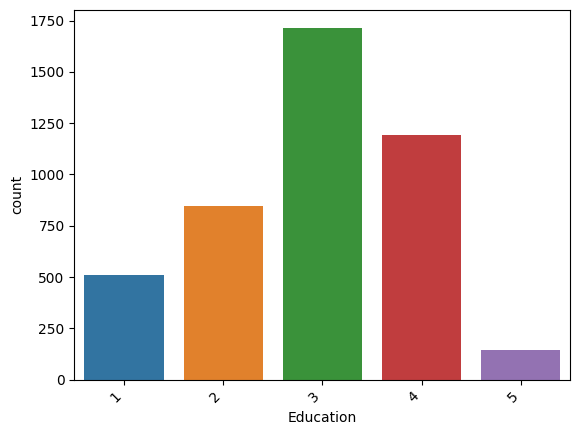

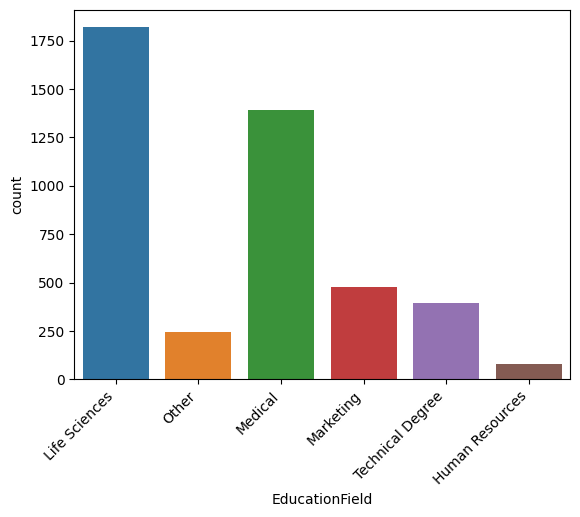

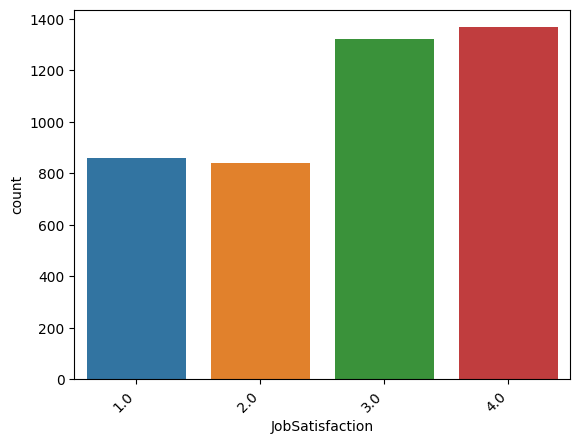

In [13]:
# creating a loop for count plots for selected categorical variables

# List of categorical columns
categorical_columns_selected = ['Education', 'EducationField', 'JobSatisfaction']

# Loop through categorical columns
for col in categorical_columns_selected:
    # Create a count plot for the current column
    sns.countplot(x=col, data=general_data)
    plt.xticks(rotation=45, ha='right')  # rotate and right-align x-axis tick labels
    plt.show()

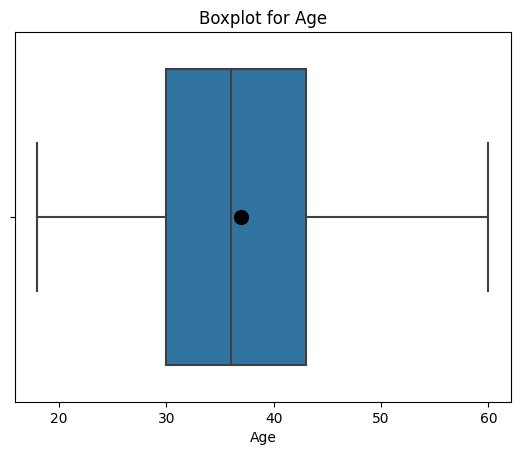

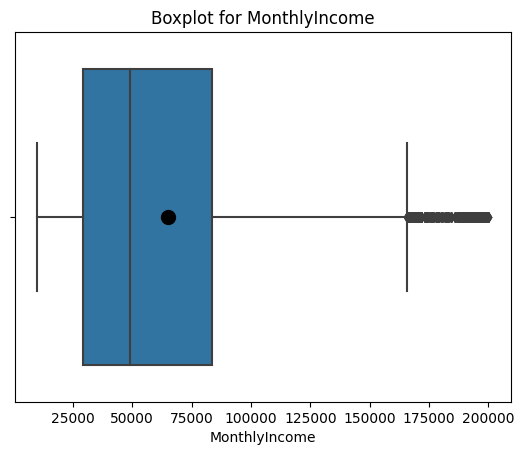

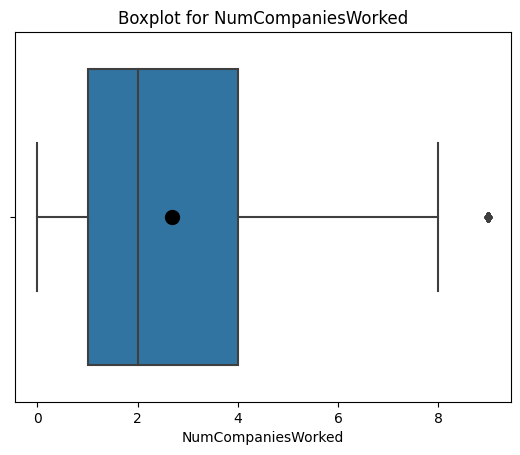

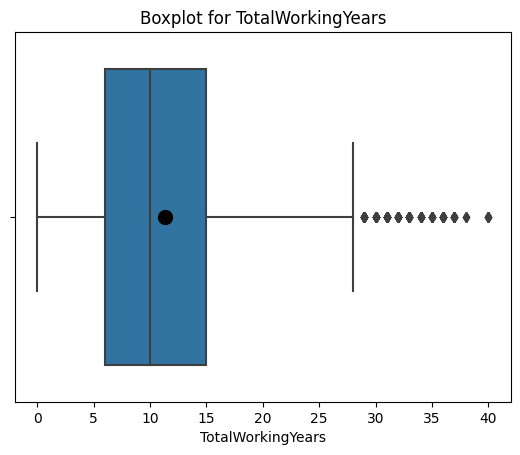

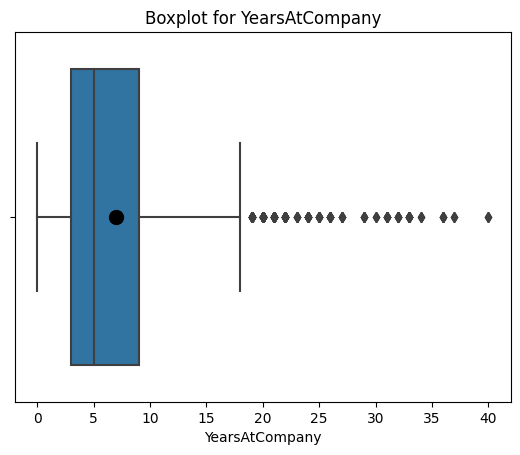

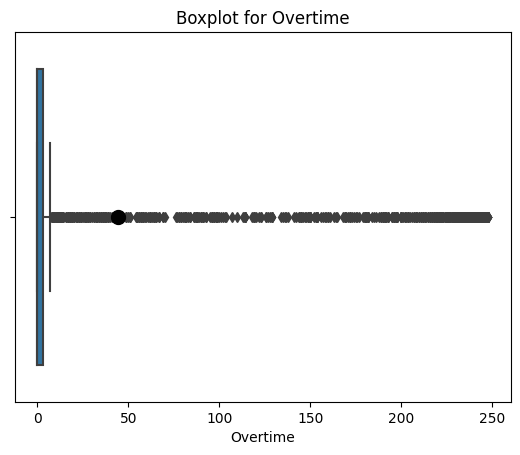

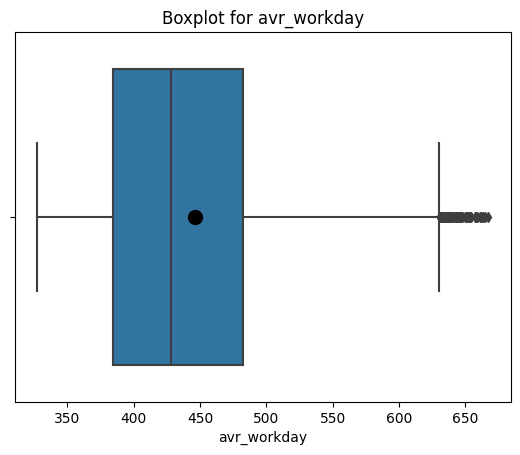

In [14]:
selected_numerical_columns = ['Age', 'MonthlyIncome', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsAtCompany', 'Overtime', 'avr_workday'] 

for col in selected_numerical_columns:  
  boxplot = sns.boxplot(x=col, data=general_data, showmeans=True, meanprops={"marker":"o",
                                                                           "markerfacecolor":"black",
                                                                           "markeredgecolor":"black",
                                                                           "markersize":"10"}) 
  plt.title(f"Boxplot for {col}") 
  plt.show()

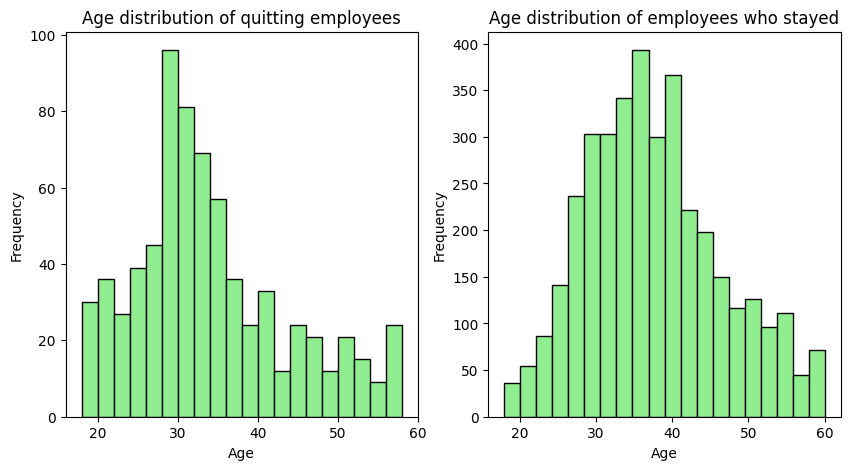

In [15]:
# Creating charts to compare Age distribution by the division of Attrition

hist_props = {'edgecolor': 'black', 'color': 'lightgreen'}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(general_data[general_data['Attrition'] == 'Yes']['Age'], bins=20, **hist_props)
ax[0].set_title('Age distribution of quitting employees')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Frequency')
ax[1].hist(general_data[general_data['Attrition'] == 'No']['Age'], bins=20, **hist_props)
ax[1].set_title('Age distribution of employees who stayed')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Frequency')
plt.show()


##### One may notice that chart, on in which there is the distribution of the employees who stayed in the company, is more similar to the normal distribution, meanwhile, the age of the employees who left is positively skewed. It means that the majority of the population lies on the left side of the chart- seems like younger people have a higher tendency to leave the company than the older ones.  Also, on the very right side of the chart of the employees who quit the company, one may see a small peak- it seems like employees who are ~60 y.o. go for retirement. 

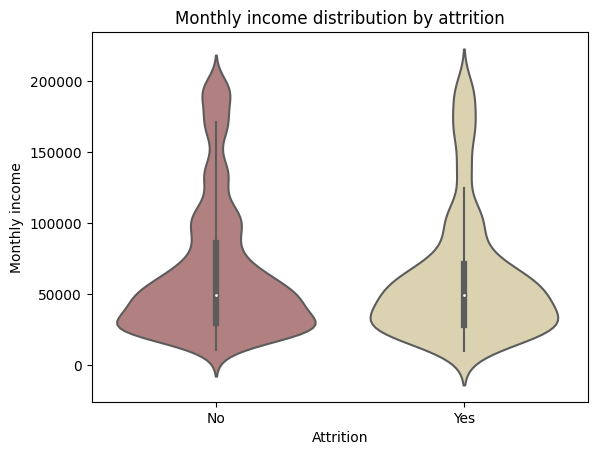

In [16]:
# Creating charts to compare Income distribution by Attrition

sns.violinplot(x='Attrition', y='MonthlyIncome', data=general_data, palette='pink', inner='box')
plt.title('Monthly income distribution by attrition')
plt.xlabel('Attrition')
plt.ylabel('Monthly income')

plt.show()

#### Comments:
    1. One may notice, that both distributions for monthly income by attrition seem to be fairly similar, even though we could expect distribution for employees who stayed to have more observations focused on higher values of income. 
    2. The median of both of the distributions, seems to be similar (approx. 50000)
    3. Mode seems to be for both of the charts similar (approx.30000)
    4. The distribution of the employees who stayed in the company has a wider range of data which can be noticed by looking at the length of whiskers. For the employees who quit, this data is slightly more focused on the mean. 
    5. The distribution of the employees who stayed in the company has more observations as outliers- it seems to be logical because usually, higher remuneration makes people stay in the company.


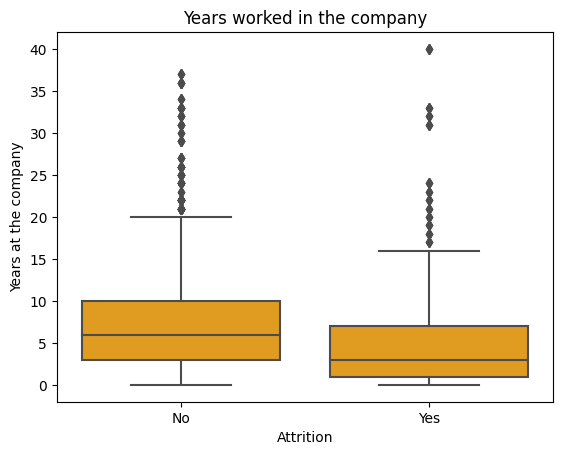

In [17]:
# Creating charts to compare Years worked in the company distribution by Attrition
sns.boxplot(x='Attrition', y='YearsAtCompany', data=general_data, color='orange')

plt.title('Years worked in the company')
plt.xlabel('Attrition')
plt.ylabel('Years at the company')

# Show the plot
plt.show()

#### Comments:
    1. Both of the distributions are positively skewed.
    2. The median for the employees who stayed in the company is approx. 6 years, and for the employees who quit approx. 4 years. 
    3. The range of the data for employees who stayed is wider than for employees who quit. 
    4. For both distributions, one may notice outliers on the right side of the distributions. For employees who quit, there are outliers far from the median- it could be assumed that these are employees who got retired (worked for company 30-40 years). 
    5. 50% of the employees who stayed, work in the company between approx. 3 and 10 years, meanwhile for the emloyees who quit this range is between approx. 1 and 7 years. 

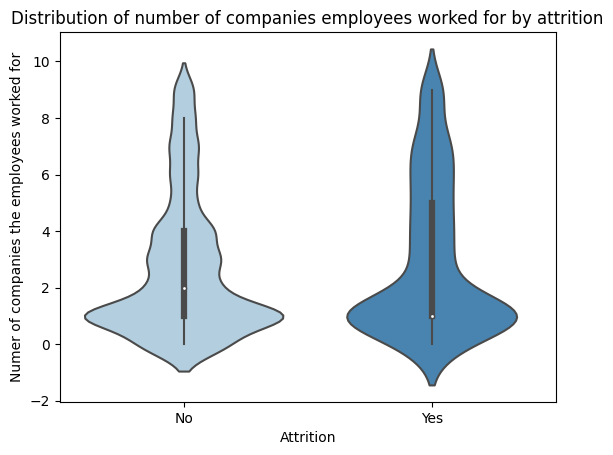

In [18]:
# Creating charts to compare distribution of Number of companies employees worked for by Attrition

sns.violinplot(x='Attrition', y='NumCompaniesWorked', data=general_data, palette='Blues', inner='box')
plt.title('Distribution of number of companies employees worked for by attrition')
plt.xlabel('Attrition')
plt.ylabel('Numer of companies the employees worked for')

plt.show()

#### Comments:
    1. Both of the distributions are positively skewed, and are fairly similar to each other.
    2. The median of the number of companies in how many employees worked, for the first group equals 2, and for the second group 1.
    3. The mode in both distributions equals 1. It might be assumed the company is hiring a lot of young people, who are also more likely to change the job.
    4. The range for the group that quit the job is slightly wider than for the group that stayed in the company. 
    5. For the employees who stayed, one may observe a slight peak of the observation around values 3 and 4. In contrast, for the employees who quit, observations align fairly evenly from value 2.

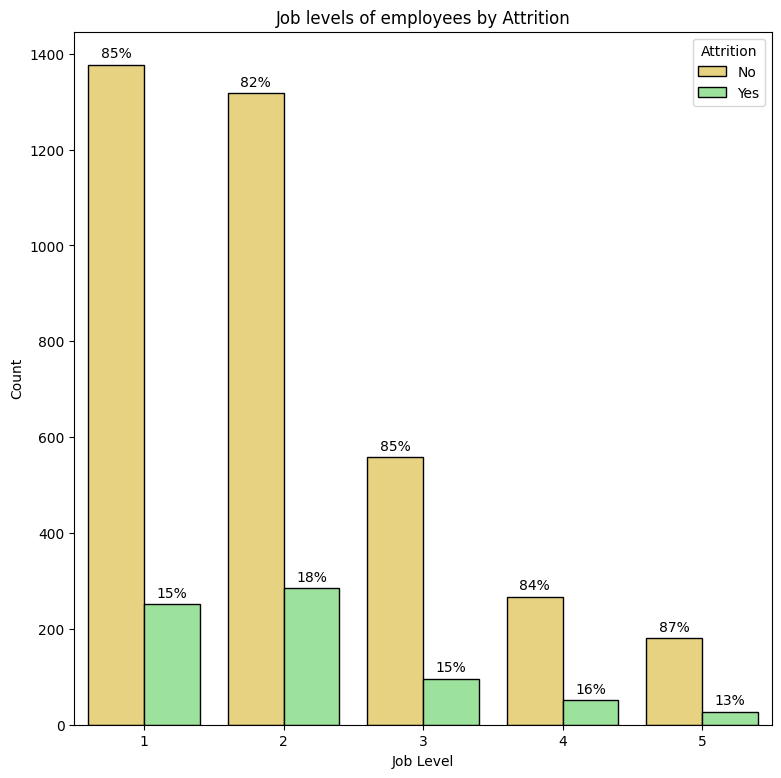

In [19]:
# Creating a chart Job levels of the employees by Attrition
plt.figure(figsize=(9,9))
ax = sns.countplot(x='JobLevel', data=general_data, hue='Attrition', palette=['#f7dc6f', '#90ee90'], edgecolor='black')
ax.set_xlabel('Job Level')
ax.set_ylabel('Count')
totals = [float(len(general_data[general_data['JobLevel']==i])) for i in range(1,6)]
ymin, ymax = ax.get_ylim()

for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = height/totals[i%5]
    x = p.get_x() + p.get_width()/2
    y = height + ymax*0.01
    ax.annotate('{:.0%}'.format(percentage), (x, y), ha='center')
    
ax.legend(title='Attrition', loc='upper right')
plt.title('Job levels of employees by Attrition')
plt.show()

#### Comments:
    1. One may notice, that the higher the job level, the smaller number of the employees in the group- which is a natural structure in most companies.
    2. One may see that the lowest rotation takes place in the group of the highest job level. This is also natural because usually executives/senior managers are less eager to change jobs.
    3. The highest rotation can be observed in the group of the 2nd job level (18%). It could be assumed, that people, who already got some work experience go to other companies for better career growth. 
    4. Generally, rotation on all levels seems to be pretty similar- between 13% and 18%.

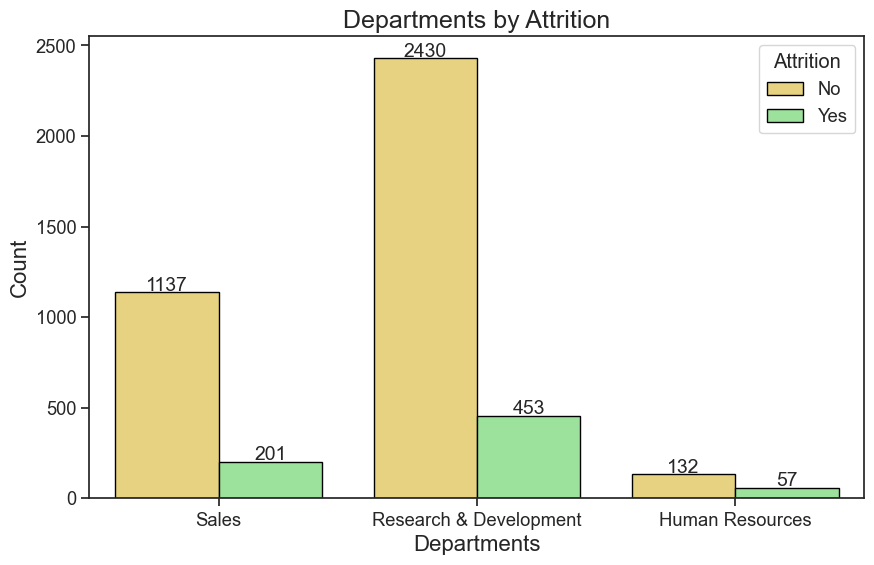

In [20]:
# Creating a chart Work-Life Balance Evaluation by employees by Attrition
sns.set(style='ticks', font_scale=1.2)
colors = ['#f7dc6f', '#90ee90']
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Department', data=general_data, hue='Attrition', palette=colors, edgecolor='black')

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+10), ha='center', fontsize=14)

ax.set_xlabel('Departments', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Departments by Attrition', fontsize=18)
ax.legend(title='Attrition', loc='upper right')
plt.show()

#### Comments:
    1. One may notice, that the highest rotation takes place in the Human Resources department (approximately 30%).
    2. In Sales and Reserach&Development the rotation is on a similar level (~15%) and it's approx. twice smaller than in HR. It would be good from a managerial point of view, to look closer at the work environment and conditions in the HR department. 

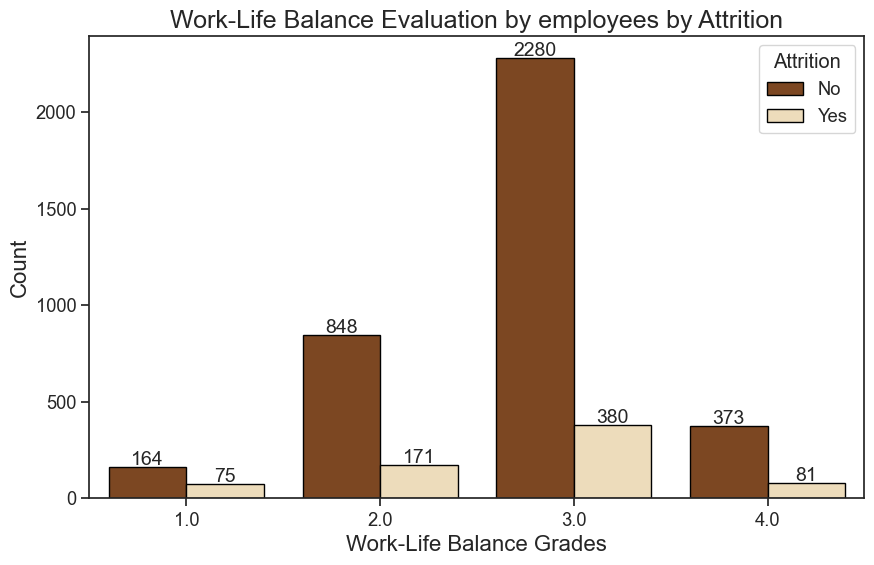

In [21]:
# Creating a chart Work-Life Balance Evaluation by employees by Attrition
sns.set(style='ticks', font_scale=1.2)
colors = ["#8B4513", "#F5DEB3"]
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='WorkLifeBalance', data=general_data, hue='Attrition', palette=colors, edgecolor='black')

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+10), ha='center', fontsize=14)

ax.set_xlabel('Work-Life Balance Grades', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Work-Life Balance Evaluation by employees by Attrition', fontsize=18)
ax.legend(title='Attrition', loc='upper right')
plt.show()

#### Comments:
    1. The employees who were not satisfied at all with the work-life balance in the company have a higher tendency of leaving (~30%). This group also was the smallest in terms of count out of all. 
    2. At the same time, employees who were satisfied, medium satisfied, and very satisfied with the work-life balance had rotation on a similar level (17-18%).
    3. Generally looking at a distribution, one may assume the company does rather a good job in delegating an accurate load of work. 

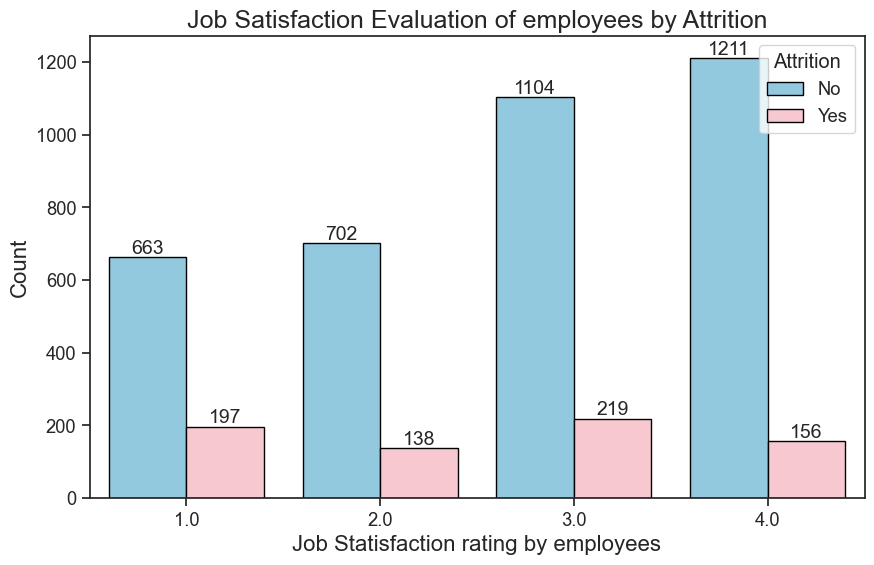

In [22]:
# Creating a chart Job Satisfaction Evaluation of employees by Attrition
sns.set(style='ticks', font_scale=1.2)
colors = ["skyblue", "pink"]
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='JobSatisfaction', data=general_data, hue='Attrition', palette=colors, edgecolor='black')

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+10), ha='center', fontsize=14)

ax.set_xlabel('Job Statisfaction rating by employees', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Job Satisfaction Evaluation of employees by Attrition', fontsize=18)
ax.legend(title='Attrition', loc='upper right')
plt.show()

#### Comments:
    1. In general, the employees are rather satisfied or very satisfied with their jobs (3 and 4). 
    2. The group with the highest rotation is the one who is not satisfied with the job (~22%). 
    3. For the employees who are medium satisfied with the job and satisfied with the job, the rotation is around 16%. For the very satisfied employees, this number drops to 11%. 

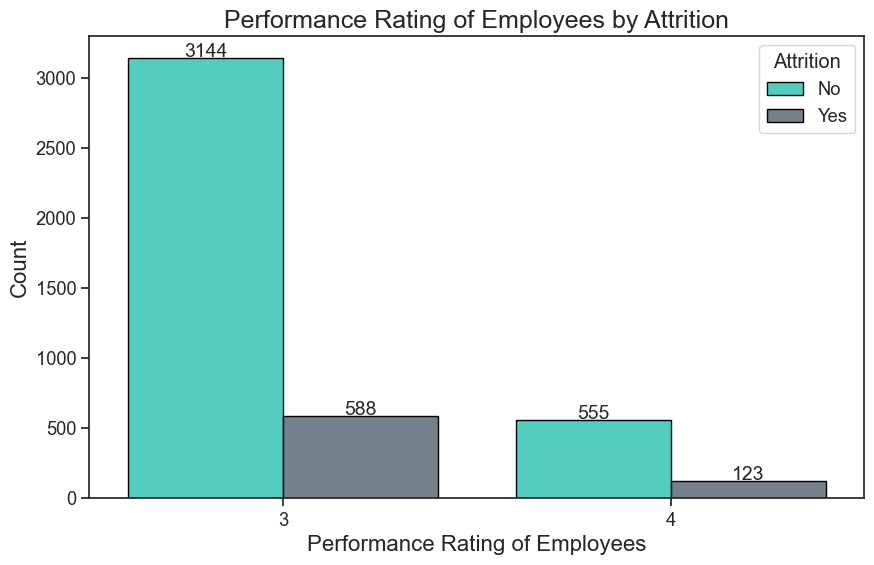

In [23]:
# Creating a chart Job Satisfaction Evaluation by employees by Attrition
sns.set(style='ticks', font_scale=1.2)
colors = ["turquoise", "slategrey"]
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='PerformanceRating', data=general_data, hue='Attrition', palette=colors, edgecolor='black')

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+10), ha='center', fontsize=14)

ax.set_xlabel('Performance Rating of Employees', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Performance Rating of Employees by Attrition', fontsize=18)
ax.legend(title='Attrition', loc='upper right')
plt.show()

#### Comments:
    1. As mentioned before, it is worth noticing, that all managers evaluated their employees' performance as excellent (3) or outstanding (4), which is quite unusual, because according to managers some of the employees were not involved in their work.
    2. The rotation among employees whose performance was graded as outstanding (15,7%) is lower than among employees whose performance was graded as excellent (18,1%).
    3. In general, one may suspect that there is some misconception during employees' evaluation. 

In [24]:
#Most of the data that meeds to be encoded is categorical - one hot encoding is selected for this purpose
#Take a df and column name and create dummy variable columns with names after its values
def one_hot_encoding(df, column_name):
    new_columns = pd.get_dummies(general_data[column_name])
    new_columns_names = [column_name + ' ' + i for i in new_columns.columns]
    new_columns_names = [i.replace(' ', '_') for i in new_columns_names]
    new_columns.columns = new_columns_names
    df = pd.concat([df, new_columns[new_columns_names[:-1]]], axis=1)
    return df

#Encoding categorical data
cols_to_decode = ['EducationField', 'MaritalStatus', 'Attrition', 'BusinessTravel', 
                  'Department', 'Gender', 'JobRole']
for column in cols_to_decode: 
    general_data = one_hot_encoding(general_data, column)
general_data.drop(cols_to_decode, axis=1, inplace=True)

#Encoding ordinal data: we have only education that is ordinal 
general_data['Education'] = general_data[
    'Education'].replace({'Below College': 1, 'College': 2 , 'Bachelor': 3, 'Master': 4, 'Doctor': 5})

# Working with missing values

In [25]:
#Getting rid of missing values. 
#For the cases where TotalWorkingYears = YearsAtCompany, we put NumCompaniesWorked = 1, for the rest of the cases we take the average of values greater than 1
general_data.loc[(general_data.TotalWorkingYears - general_data.YearsAtCompany)==0, 'NumCompaniesWorked']=1
general_data.NumCompaniesWorked = general_data.NumCompaniesWorked.fillna(
    round(general_data[general_data.NumCompaniesWorked>1].NumCompaniesWorked.mean()))

In [26]:
#Where NumCompaniesWorked = 1, we change missing values for TotalWorkingYears with YearsAtCompany
filt = (general_data.NumCompaniesWorked<=1)&(general_data.TotalWorkingYears.isnull())
general_data.loc[filt, 'TotalWorkingYears']=general_data.loc[filt,'YearsAtCompany']

#For the rest of the cases, we multiply YearsAtCompany by average of TotalWorkingYears to YearsAtCompany ratio
ratio = general_data.TotalWorkingYears.sum()/general_data.YearsAtCompany.sum()
filt = (general_data.TotalWorkingYears.isnull())
general_data.loc[filt, 'TotalWorkingYears'] = round(general_data.loc[filt, 'YearsAtCompany']*ratio)

In [27]:
#For the rest of the cases, we simply sub
for col in ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']:
    general_data[col] = general_data[col].fillna(general_data[col].mean()).map(round)

In [28]:
# Double checking to see there are no null values in the df
no_nulls = general_data.isnull().sum().sum() == 0
print(f"All columns not null: {no_nulls}")

All columns not null: True


In [29]:
general_data.columns

Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeID', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'avr_workday', 'Days_out', 'Overtime', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement',
       'PerformanceRating', 'EducationField_Human_Resources',
       'EducationField_Life_Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'MaritalStatus_Divorced', 'MaritalStatus_Married', 'Attrition_No',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'Department_Human_Resources', 'Department_Research_&_Development',
       'Gender_Female', 'JobRole_Healthcare_Representative',
       'JobRole_Human_Resources', 'JobRole_Laboratory_Technician',
       'JobRole_Manager', 'JobRole_Manufa

### Creating a correlation heatmap


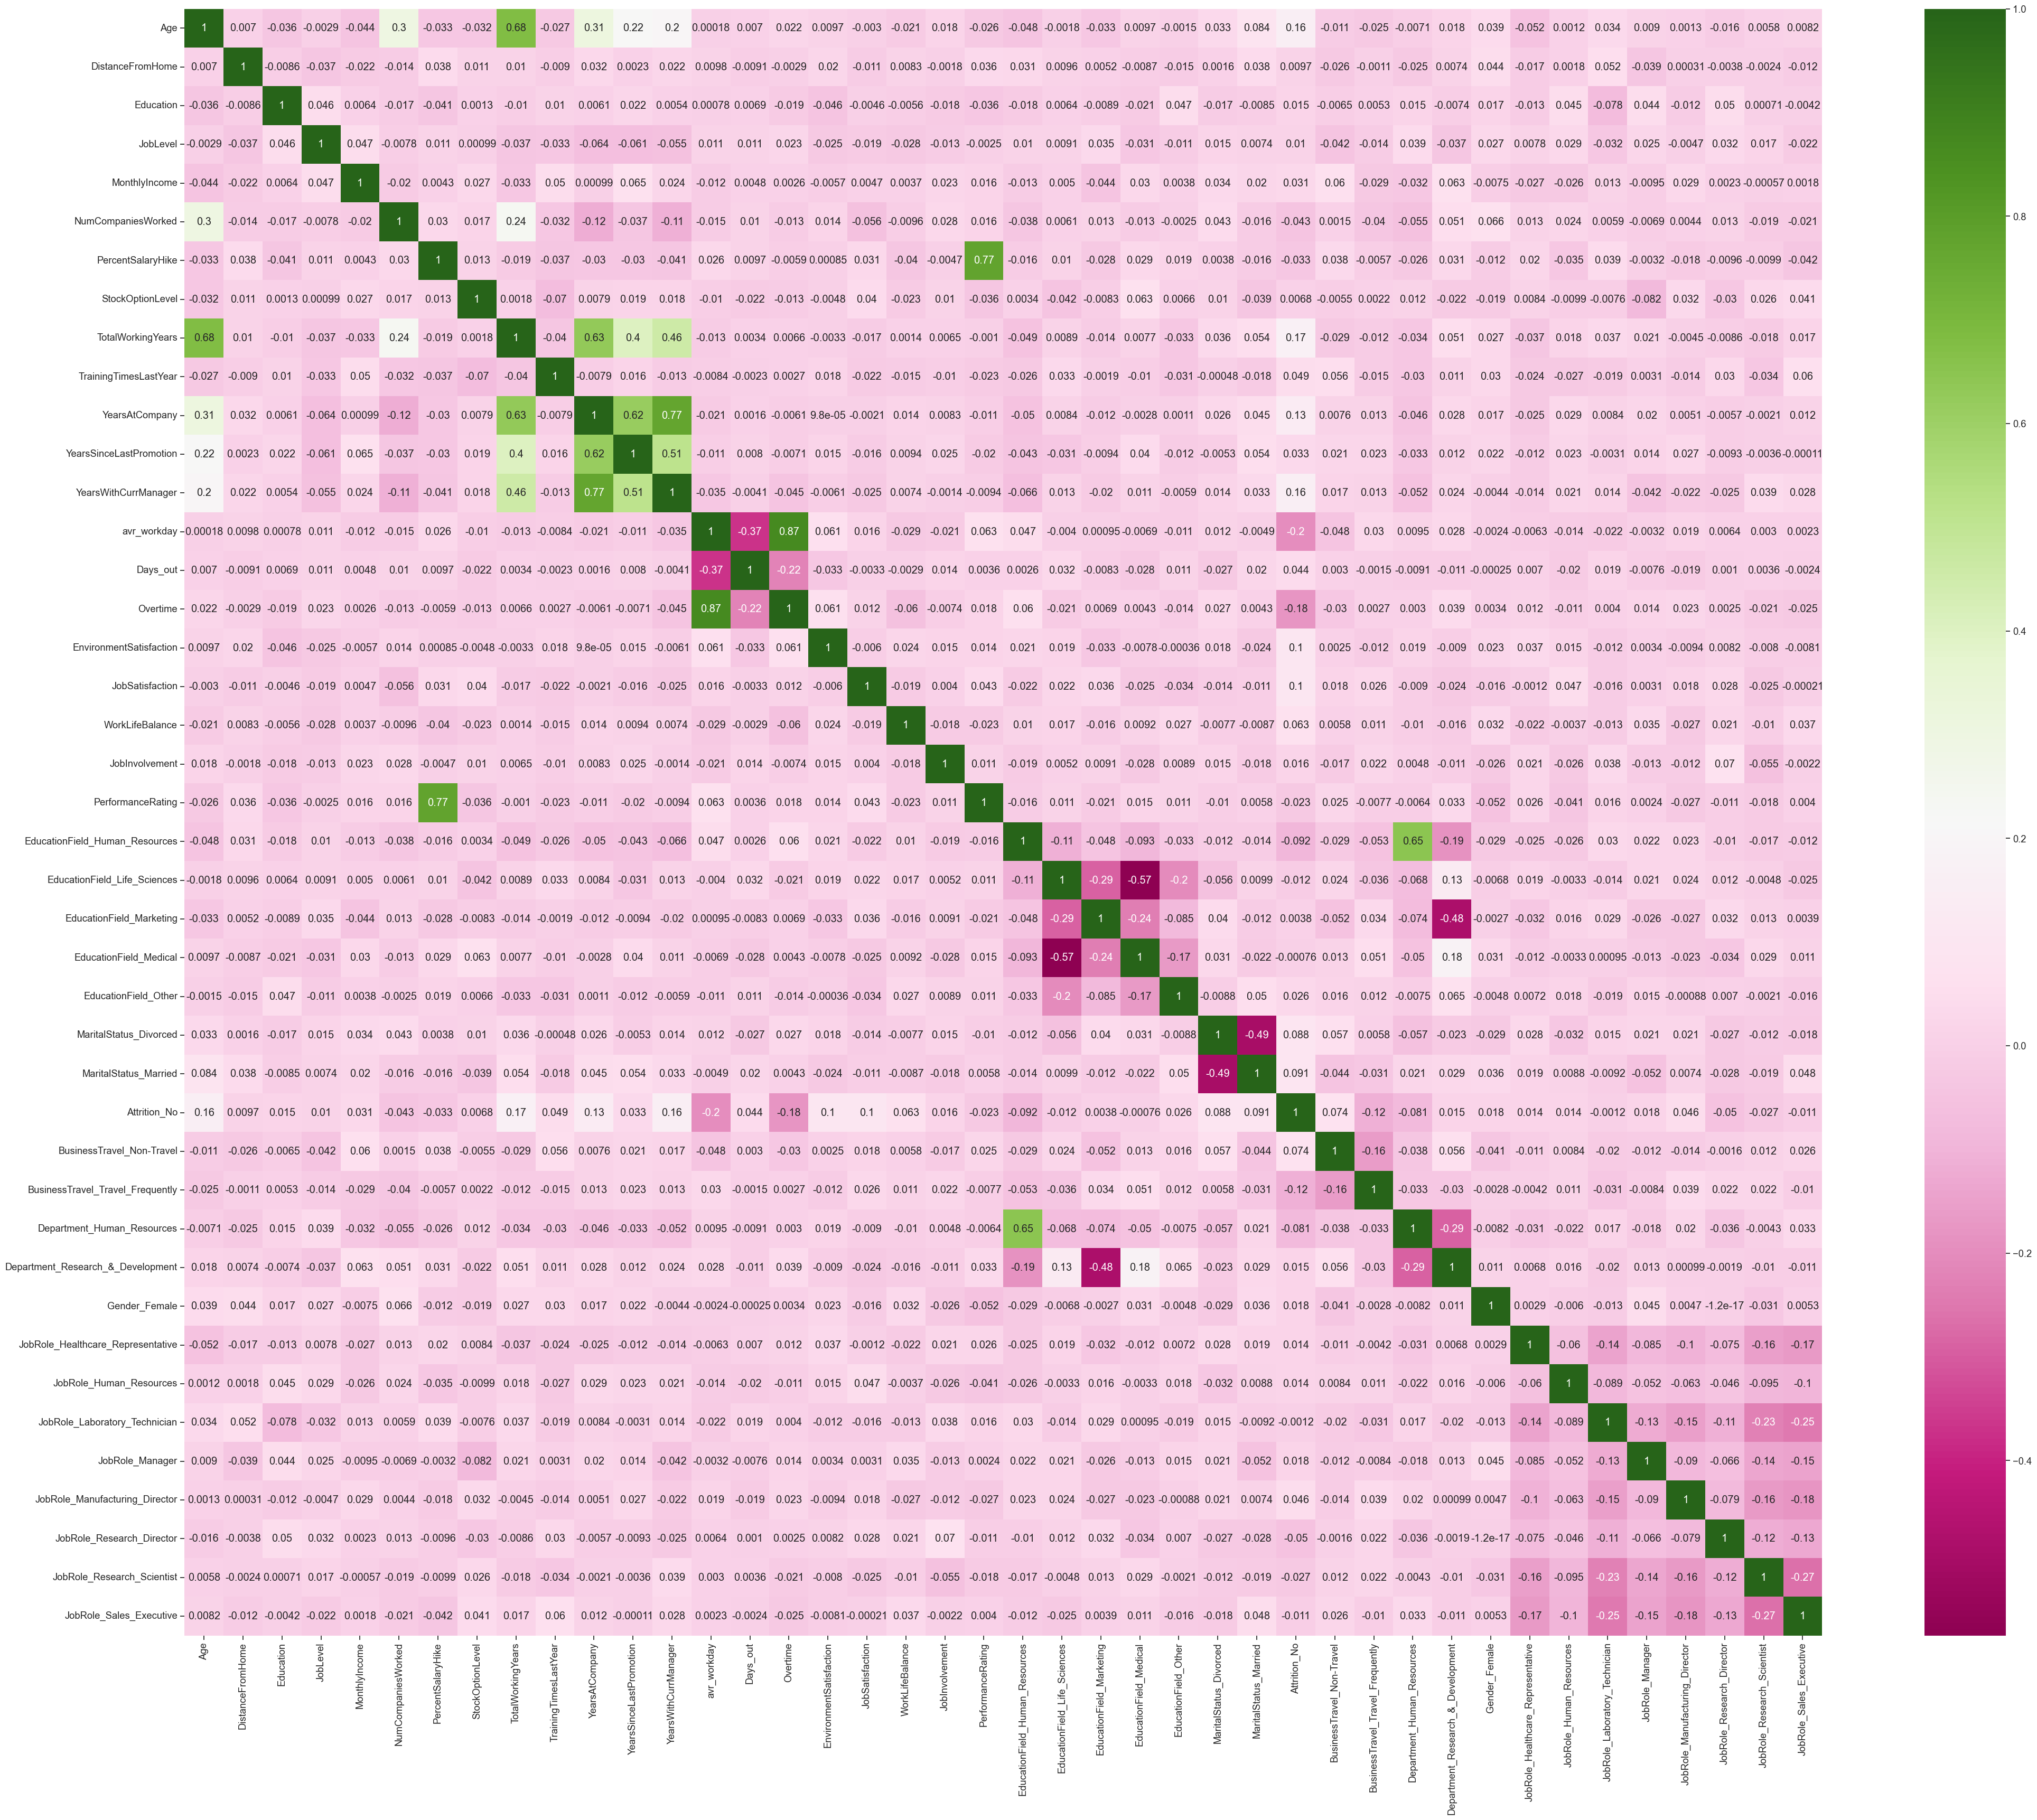

In [30]:
# Excluding 'EmployeeID' too since the df is complete and it is not needed from here.

general_data_2 = general_data.drop(['EmployeeID'], axis = 1)

plt.figure(figsize = (50,40))  
sns.heatmap(general_data_2.corr(),annot = True,cmap="PiYG") 
plt.show() 


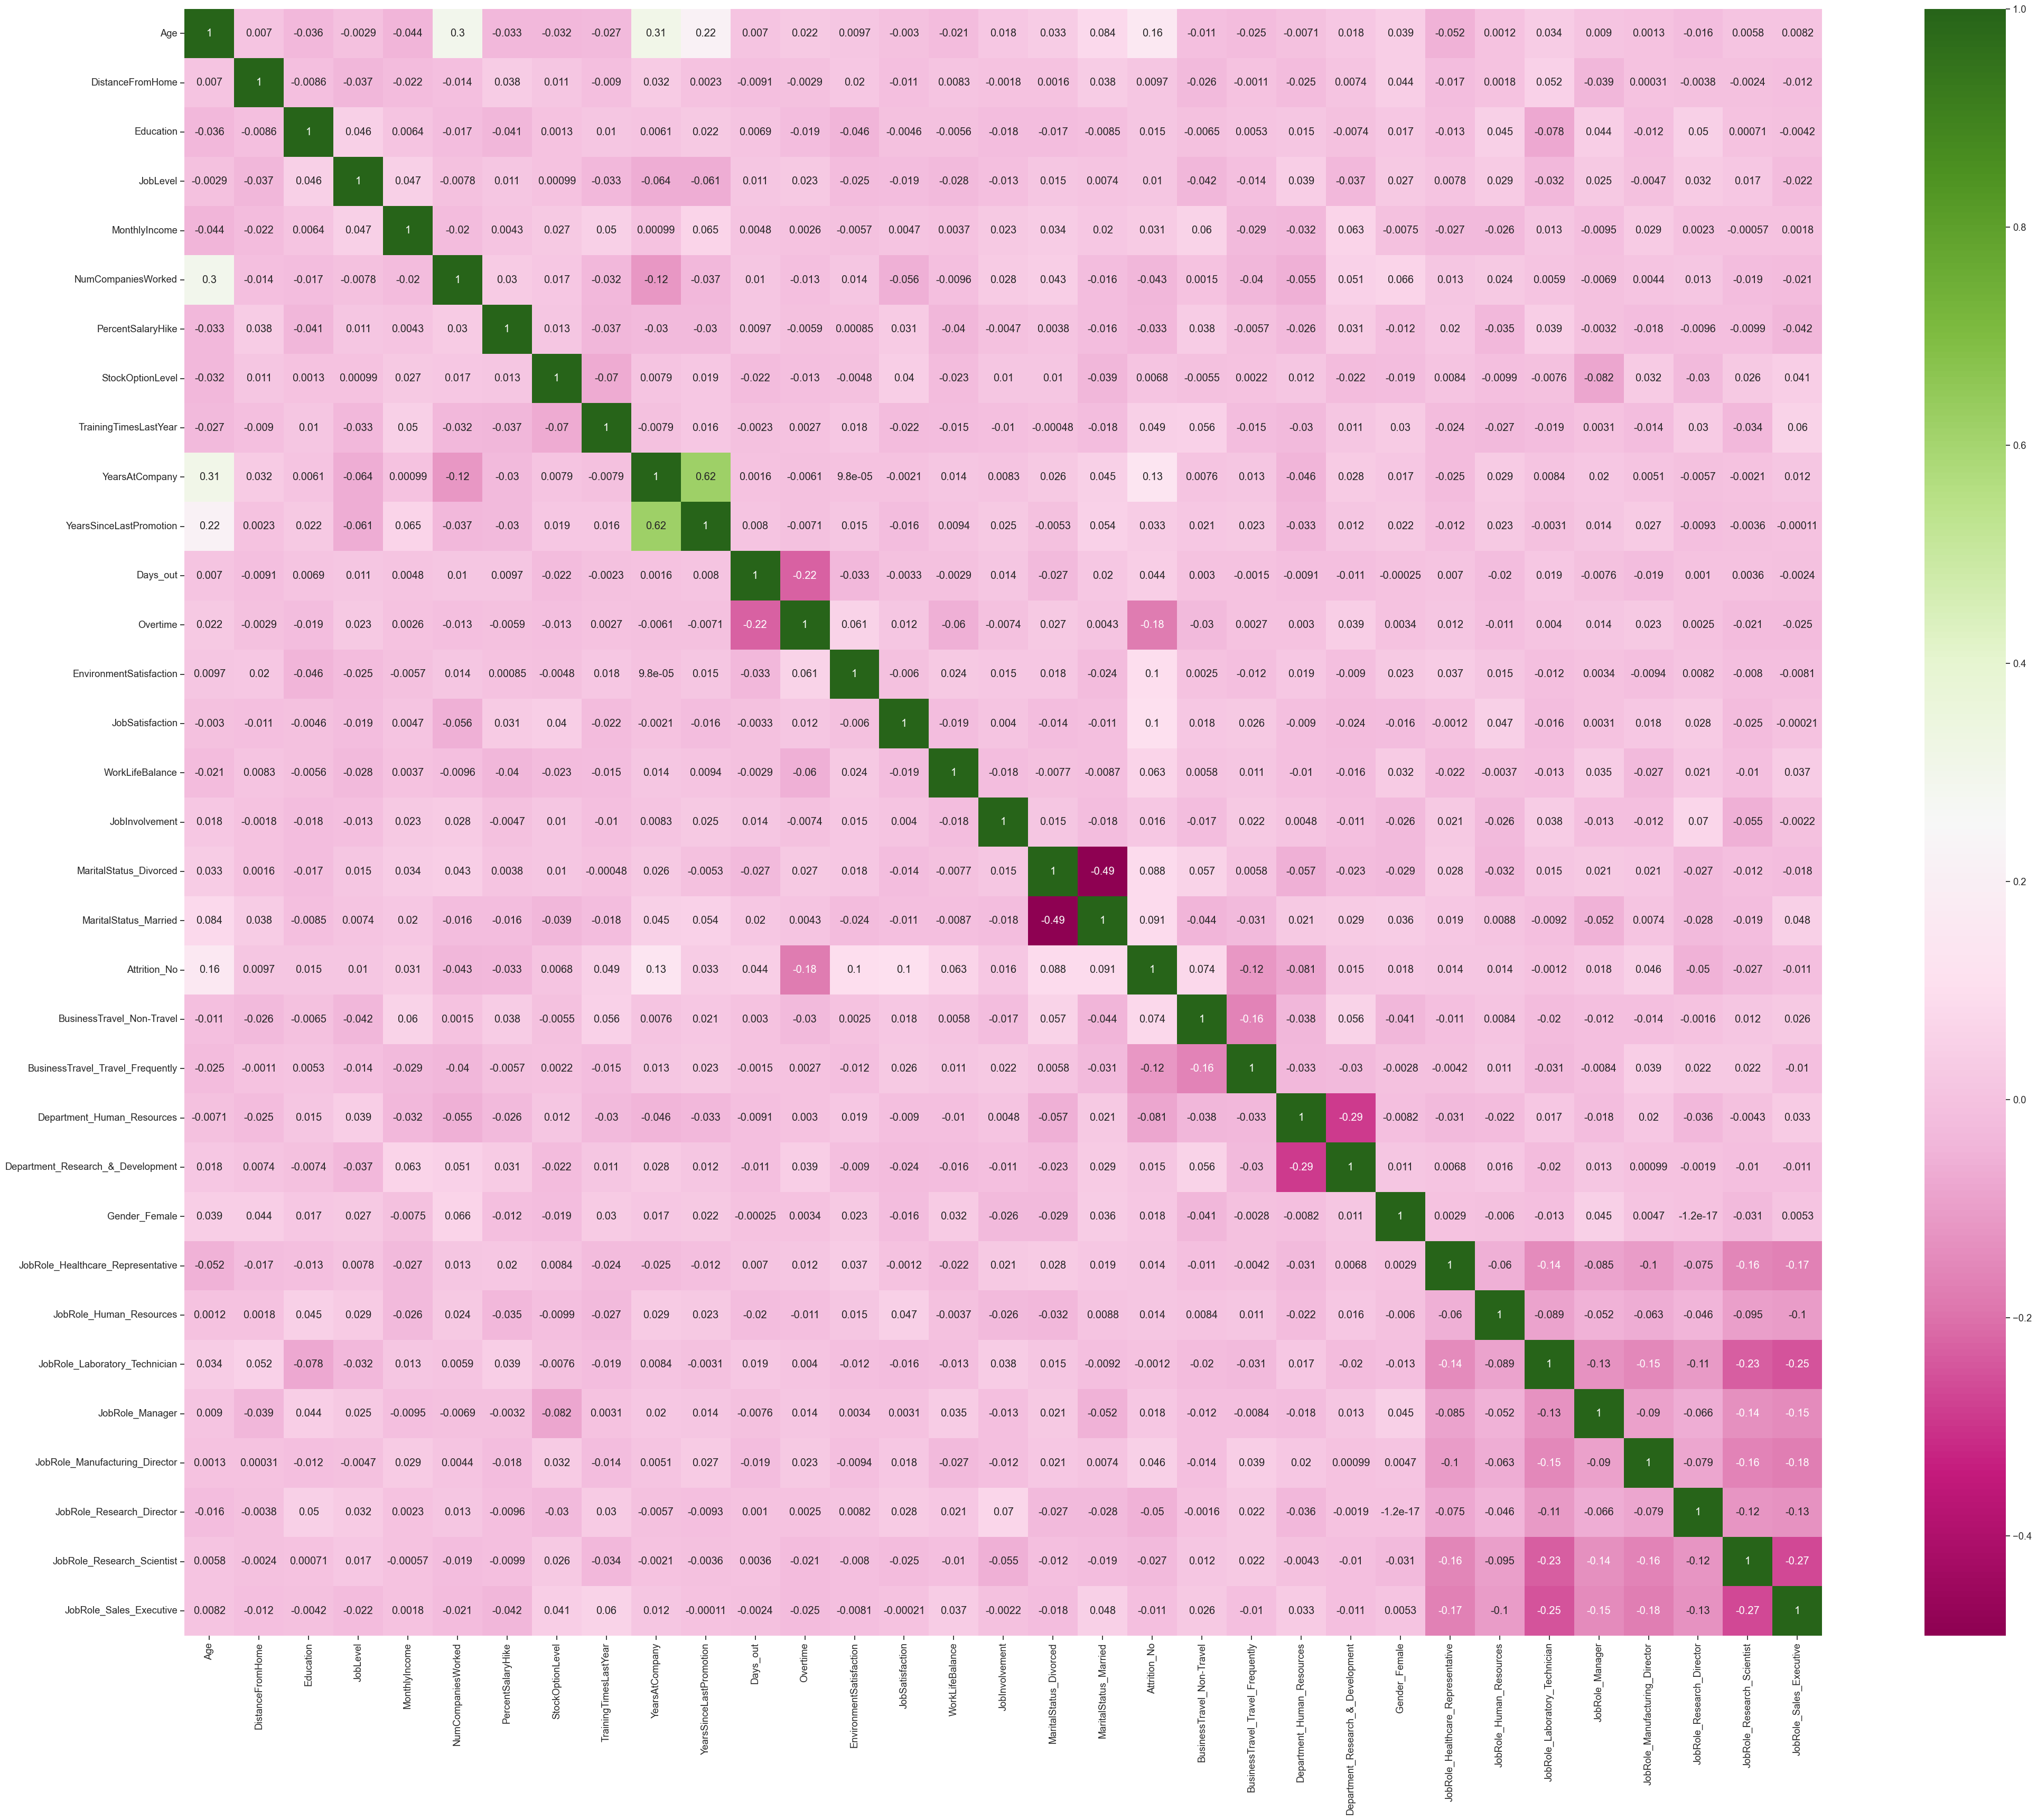

In [31]:
# Create a correlation heatmap after removing the variable where the multicollinearity can be observed

dataframe = general_data_2.drop(['EducationField_Human_Resources', 'EducationField_Life_Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'TotalWorkingYears', 'YearsWithCurrManager', 'PerformanceRating', 'avr_workday'], axis = 1)

plt.figure(figsize = (50,40))  
sns.heatmap(dataframe.corr(),annot = True,cmap="PiYG") 
plt.show() 

## We excluded variables as follow:
    #1 Variables related to education: 'EducationField_Human_Resources', 'EducationField_Life_Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other'
        # These variables were strongly correlated with the names of departments where the employees work. We decided that for our analysis, it is more cruical to know in which department employees work than what education filed they obtained, thus education was removed. 
    #2 PerformanceRating was strongly correlated with PercentageSalaryHike (0.77). Generally the higher performance evaluation employee gets, the more probable salary increase is for a given employee. We decided to drop the PerformanceRating, because we believe, that for the employee salary increase has bigger motivation value than evaluation itself. 
    #3 TotalWorkingYears was strongly correlated with Age (0.68) and YearsAtCompany (0.63), which is understandable, yet we decided to drop the TotalWorkingYears, because Age and YearsAtCompany together curry very similar information and at the same time bring better value for analysis. 
    #4 YearsWithCurrentManager was strongly correlated with YearsAtCompany (0.77) which is understandable because most of the people will work entire time in one team, and unless the rotation on manager position occurs, they will be working with the same manager. In our opinion these two variables present similar set of information, thus we decided to drop YearsWithCurrManager which seems less significant for the analysis. 

## Altough there are 2 variables that have semi-strong correlation that are YearsSinceLastPromotion and YearsAtCompany (0.62) we decided to keep them, because in our opinion they represent different sort of information, because YearsSinceLastPromotion can point at the level of seniority (the higer you are in a hierarchy, the longer you wait for the promotion). 


#### Presenting the final list of the independent variables and their correlation with our dependent variable - Attrition before we move on to building the model


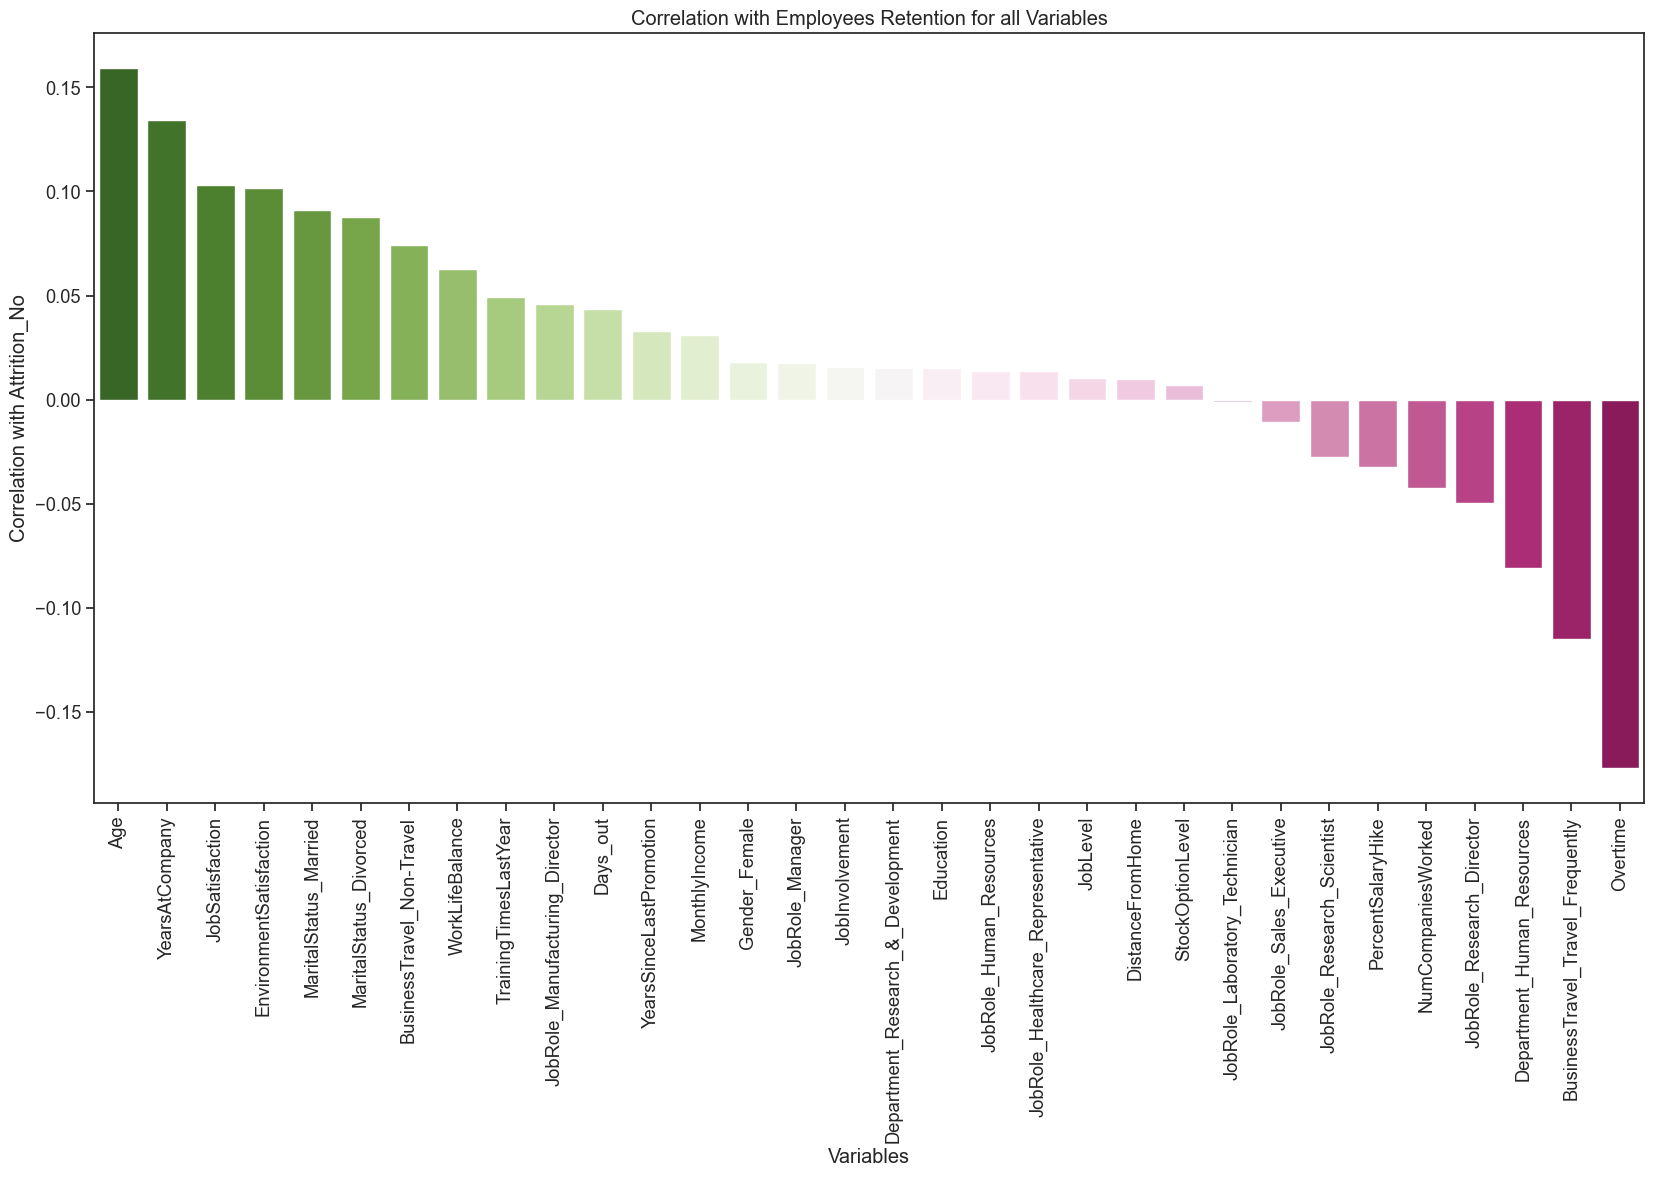

In [32]:
plt.figure(figsize=(20, 10))

# Computing correlation matrix and filtering corr values for 'Attrition_No'
corr_matrix = dataframe.corr()
corr_attrition = corr_matrix['Attrition_No'].sort_values(ascending=False).drop('Attrition_No')

# Creating boxplot with defined color palette
colors = sns.color_palette("PiYG_r", len(corr_attrition))
ax = sns.barplot(x=corr_attrition.index, y=corr_attrition.values, palette=colors)

# Setting axis labels and title
ax.set_xlabel('Variables')
ax.set_ylabel('Correlation with Attrition_No')
ax.set_title('Correlation with Employees Retention for all Variables')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

## According to our results:
#### Among the most positively correlated variables are:
    1. Age: the older the employee is, the less likely he/she is to leave the company;
    2. YearsAtCompany: the longer the employee works for the company, the less likely he/she is to leave the company;
    3. JobSatisfaction: the more satisfied the employee is in the current role, the less likely he/she is to leave the company;
    4. EnvironmentSatisfaction: the more satisfied the employee is with the environment, the less likely he/she is to leave the company;
    5. MaritalStatus Married and Divorced: if the employee is married or divorced, he/she is less likely to leave (in comparison to single) 
#### Among the most negatively correlated are:
    1. Overtime: the more overtime days employee has, the more likely he/she will leave the company;
    2. BusinessTravel_Frequently: if the employee travels frequently for work, he/she is more likely to decide to leave the company;
    3. DepartmentHR: if the employee work in the HR department, he/she is more likely to leave the company;
    4. JobRole_ResearchDirector: if the employee work as Research Director, he/she is more likely to leave the company;
    5. NumCompaniesWorked: the more employers the employee was associated with before, the more likely he/she will leave the company.

Contrary to expectations, PercentSalaryHike is negatively correlated with Attrition. Although the company tries to improve retention rate by giving the employees salary increases at the moment of their potential attrition, this only shows to have a weak short-term result.
    

### Building a Logistic Regression Model

In [33]:
# splitting the df into a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(['Attrition_No'], axis=1), dataframe['Attrition_No'], test_size = 0.3, random_state = 42)

In [34]:
# Scaling the data to have a mean 0 and standard deviation of 1
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[X_train.columns.values]), columns=[X_train.columns.values]) 
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test[X_test.columns.values]), columns=[X_test.columns.values]) 

In [35]:
# Preparing hyperparameters for cross validation
param_grid = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-5,8,15),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [36]:
# Initiating the logreg classifier, fitting and predicting
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, scoring='accuracy', cv=10)
logreg_cv.fit(X_train_scaled,y_train)
y_pred = logreg_cv.predict(X_test_scaled)

In [37]:
# Tuned hyperparameters and score
print(f"Tuned Logistic Regression Hyperparameters : {logreg_cv.best_params_}")
print(f"Tuned Logistic Regression Model Score: {logreg_cv.score(X_test_scaled, y_test)}")

Tuned Logistic Regression Hyperparameters : {'C': 0.05179474679231213, 'penalty': 'l2', 'solver': 'newton-cg'}
Tuned Logistic Regression Model Score: 0.854119425547997


In [38]:
# Using the tuned hyperparameters to fit the model
logreg = LogisticRegression(C= 0.05179474679231213 , penalty= 'l2', solver= 'newton-cg')
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)
print(f"Tuned model score: {round(100*logreg.score(X_test_scaled, y_test), 2)}%")

Tuned model score: 85.41%


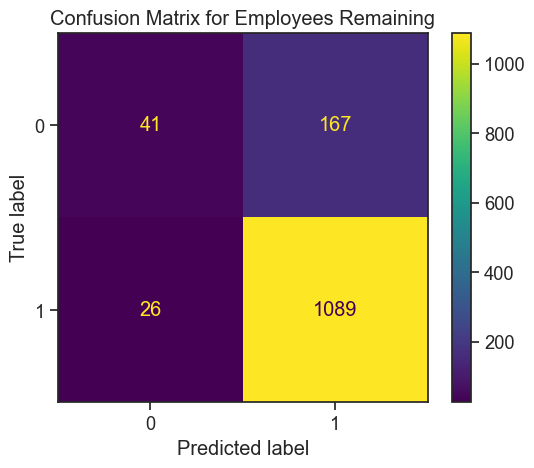

In [39]:
# Calculate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=logreg.classes_)
disp.plot()
disp.ax_.set_title('Confusion Matrix for Employees Remaining')
plt.show()

In [40]:
target_names = ['Leave', 'Remain']
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

       Leave       0.61      0.20      0.30       208
      Remain       0.87      0.98      0.92      1115

    accuracy                           0.85      1323
   macro avg       0.74      0.59      0.61      1323
weighted avg       0.83      0.85      0.82      1323



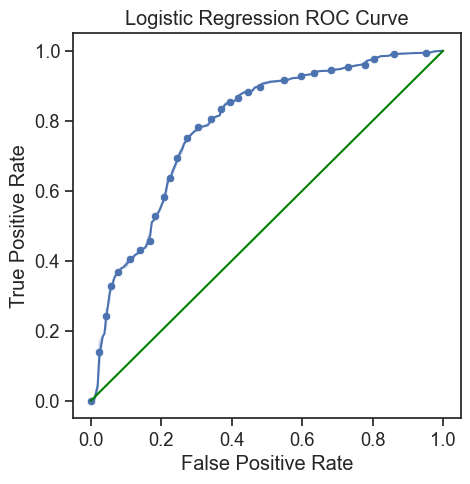

In [41]:
# Plotting the ROC curve of the model
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize = (5, 5))
sns.scatterplot(x = fpr[::10], y = tpr[::10])
sns.lineplot(x = fpr, y = tpr)
sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Logistic Regression ROC Curve')
plt.show()

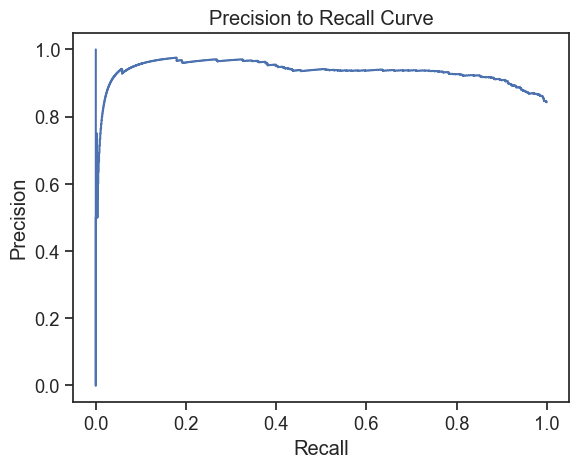

In [42]:
prec, recall, _ = precision_recall_curve(y_test, logreg.decision_function(X_test_scaled), pos_label=logreg.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
pr_display.ax_.set_title('Precision to Recall Curve')
plt.show()

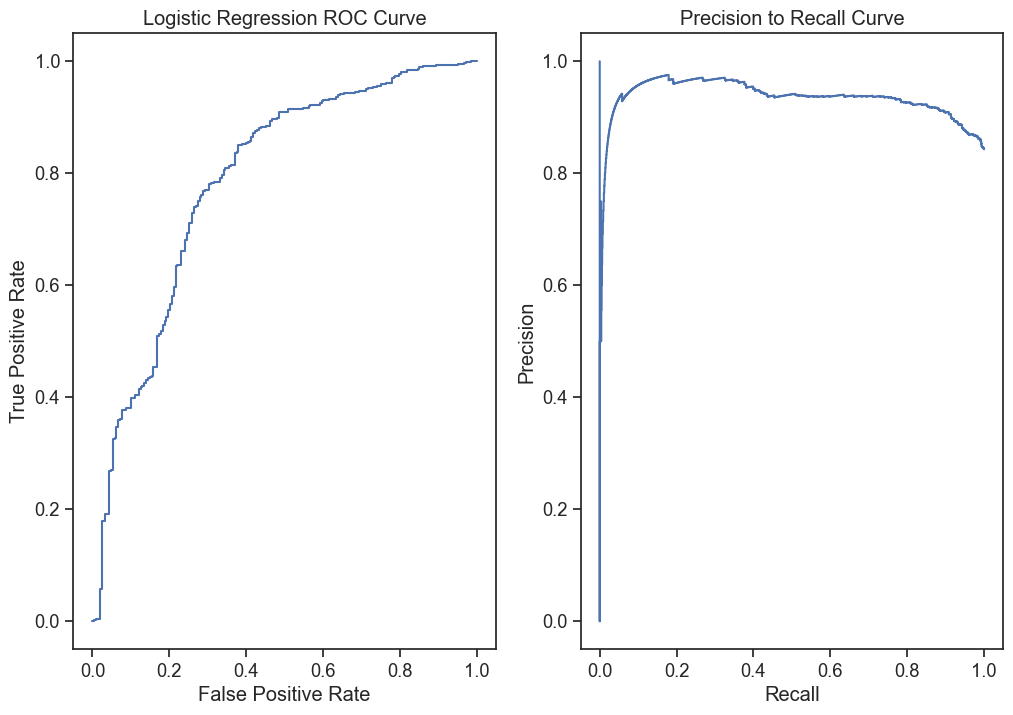

In [43]:
# Plot the ROC and P/R curves together to compare

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)
roc_display.ax_.set_title('Logistic Regression ROC Curve')
pr_display.plot(ax=ax2)
pr_display.ax_.set_title('Precision to Recall Curve')
plt.show()

In [44]:
# Calculating the area of the area under the curve (AUC)
print(f"AUC score: {100*roc_auc_score(y_test, y_pred_prob):.2f}%")

AUC score: 78.72%


In [45]:
idx = np.argmax(tpr - fpr)
print(f"Probability threshold cutoff: {100*round(thresholds[idx], 2)}%")

Probability threshold cutoff: 81.0%
